### Rough Heston model 
The rough Heston model is given by
   
   $dS_t = S_t\sqrt{V_t}dW_t $

   $V_t = V_0 + \frac{\gamma}{\Gamma(H + \frac{1}{2})}\int_{0}^{t}(t-s)^{H - \frac{1}{2}}(\theta - V_s)ds + \frac{\gamma \nu}{\Gamma(H + \frac{1}{2})}\int_{0}^{t}(t-s)^{H-\frac{1}{2}}\sqrt{V_s}dB_s$
 
   where $\gamma, \theta, \nu, \rho$ is the set of parameters, $W$ and $B$ are correlated with $\rho$, and $V_0$ is known. 
    
   Decompose the time interval $I = $\[$0,T$\] into $M$ uniform subintervals $I_n \colon= [t_n, t_{n+1}]$ for $n = 0, 1,\cdots,M-1$ of size $\tau = \frac{T}{M}$, $t_n = n \times \tau$, for $n=0,1,\cdots,M$.
   
   Note that $t^{H-\frac{1}{2}}\approx \sum_{j=1}^{N}\omega_je^{-\lambda_jt}$, where $\{\omega_j\}_{j=1}^{N}$ and $\{\lambda_j\}_{j=1}^{N}$ are unique for all $t \in (0, T]$
   
   For $V_{t_i}$, let $F_{a,i} \colon= \int_{0}^{t_i}(t_i-s)^{H-\frac{1}{2}}(\theta - V_s)ds$, $F_{b,i} \colon= \int_{0}^{t_i}(t_i-s)^{H - \frac{1}{2}}\sqrt{V_s}dB_s$.    

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt 
import time 
from scipy.optimize import bisect
from scipy.special import gamma 
from scipy import integrate

In [2]:
#sum of exponentials to approximate t^{-a-1}
#in our case, let -a-1 = H - 0.5, then a = -H - 0.5
def para(a, delta_t, n):
    delta = 1   
    tau = np.pi/np.sqrt(delta*n) 

    i = np.arange(-n,n+1,1) #i= -n,...,0,...,n, N = 2×n + 1 
    Lambda = np.log(1+ np.exp(tau*i))/delta_t 
    Omega = tau*(np.log(1+np.exp(tau*i)))**a/(1+np.exp(-tau*i))/(delta_t**(1 + a)*gamma(1 + a)) 
    
    return Omega, Lambda 

In [3]:
#BS formula 
def BS(flag, S0, K, T, r, vol):
    #for call option, flag = True; for put option, flag = False 
    #D: discount factor 
    #r: risk-free interest rate
    #F: forward price := S0/D

    vsqrt = vol*np.sqrt(T)
    D = np.exp(-r*T)
    F = S0/D
    d1 = np.log(F/K)/vsqrt + vsqrt/2
    d2 = d1 - vsqrt
    
    if Flag:
        return D*(F*norm.cdf(d1) - K*norm.cdf(d2))
    else:
        return D*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    
def impliedvol(C, S0, K, T, r): #by bisection algorithm
    #C: call option price 
    def smileMin(vol, *args):
        C, S0, K, T, r = args 
        return C - BS(True, S0, K, T, r, vol)
    vMin = 0.000001
    vMax = 10
    return bisect(smileMin, vMin, vMax, args = (C, S0, K, T, r), 
                 rtol = 1e-15, full_output=False, dsip=True)



In [4]:
class rough_Heston_Analytical: 
    def __init__(self, M, T, params, Omega, Lambda, N, P):
        #Time discretization
        self.M = M #number of time intervals 
        self.T = T
        self.tau = self.T/self.M
        self.grid = np.linspace(0, T, self.M+1)
        self.Omega = Omega #(N,) 1-d array: 𝜔_1, 𝜔_2,...,𝜔_N
        self.Lambda = Lambda # (N,) 1-d array: 𝜆_1, 𝜆_2,...,𝜆_N       
        self.N = N
        self.P = P #number of paths to generate       
        
        #Heston model parameters 
        self.S0 = params['S0']
        self.V0 = params['V0']
        self.Gamma = params['Gamma']
        self.nu = params['nu']
        self.theta = params['theta']
        self.rho = params['rho'] 
        self.H = params['H']
        
        #Precomputation
        self.Omega_t = self.Omega/self.tau
        self.E = np.exp(-1*self.Lambda*self.tau)  
        self.coef_1 = self.Gamma / gamma(self.H + 0.5) 
        self.coef_2 = self.coef_1*self.nu       
        
        
    #Brownian motions W and B
    def BW(self): 
        np.random.seed(0)
        W = np.sqrt(self.tau)*np.random.normal(loc=0, scale=1, size = [P,M]) 
        Z = np.sqrt(self.tau)*np.random.normal(loc=0, scale=1, size = [P,M]) 
        B = self.rho*W + np.sqrt(1-self.rho**2)*Z #W and B correlated with rho
        return W, B 
        
    #compute C_1 and C_2 
    def C(self):
        C_1 = np.zeros((self.M, self.N))
        C_2 = np.zeros((self.M, self.N))
            
        #1st row of C_1 and C_2
        t1 = self.grid[1]
        for j in range(self.N):
            C_1[0,j] = integrate.quad(lambda x: np.exp(-1*self.Lambda[j]*(t1-x))*(t1-x), 0, t1)[0]
            C_2[0,j] = integrate.quad(lambda x: np.exp(-1*self.Lambda[j]*(t1-x))*x, 0, t1)[0]
        
        #2nd ∼ Mth rows of C_1 and C_2
        for i in range(1, self.M):
            t_a = self.grid[i]
            t_b = self.grid[i+1]
            for k in range(self.N):
                C_1[i,k] = integrate.quad(lambda x: np.exp(-1*self.Lambda[k]*(t_a-x))*(t_b-x), t_a, t_b)[0]
                C_2[i,k] = integrate.quad(lambda x: np.exp(-1*self.Lambda[k]*(t_a-x))*(x-t_a), t_a, t_b)[0]
        
        return C_1, C_2
        
    #compute Pi_1 and Pi_2
    def Pi(self):         
        Pi_1 = np.zeros((self.P, self.M, self.N)) #a 3-d array, or total P numbers of M×N 2-d arrays
        Pi_2 = np.zeros((self.P, self.M, self.N))
        W,B = self.BW()
        
        #1st row 
        t1 = self.grid[1]
        for i in range(self.P):
            for k in range(self.N):
                f_1 = integrate.quad(lambda x: np.exp(-2*self.Lambda[k]*(t1-x))*(t1-x)**2, 0, t1)[0]
                f_2 = integrate.quad(lambda x: np.exp(-2*self.Lambda[k]*(t1-x))*x**2, 0, t1)[0]
                Pi_1[i,0,k] = np.sqrt(f_1)*B[i, 0] 
                Pi_2[i,0,k] = np.sqrt(f_2)*B[i, 0]
            
        #2nd ∼ Mth rows 
        for i in range(self.P):
            for j in range(1,self.M):
                t_a = self.grid[j]
                t_b = self.grid[j+1]
                for k in range(self.N):
                    f_1 = integrate.quad(lambda x: np.exp(-2*self.Lambda[k]*(t_a-x))*(t_b-x)**2, t_a, t_b)[0]
                    f_2 = integrate.quad(lambda x: np.exp(-2*self.Lambda[k]*(t_a-x))*(x-t_a)**2, t_a, t_b)[0]
                    Pi_1[i,j,k] = np.sqrt(f_1)*B[i,j]
                    Pi_2[i,j,k] = np.sqrt(f_2)*B[i,j]                   
     
        return Pi_1, Pi_2
        
    def V_(self):
        V = np.zeros((self.P, self.M))          
        G = np.zeros((self.P, self.M, self.N))
        Phi = np.zeros((self.P, self.M, self.N))
        
        #multiply Omega_t to C and Pi by row  
        C_1, C_2 = self.C()
        Pi_1, Pi_2 = self.Pi()
        C_1_t = self.Omega_t * C_1
        C_2_t = self.Omega_t * C_2  
        Pi_1_t = self.Omega_t * Pi_1 
        Pi_2_t = self.Omega_t * Pi_2
        
        #Compute 1st col of V
        m_1_1 = self.theta - self.V0
        C_s_1 = m_1_1*C_1_t[0,:]
        C_a_1 = m_1_1*C_2_t[0,:]
        
        m_2_1 = np.sqrt(self.V0)
        Pi_s_1 = m_2_1*Pi_1_t[:,0,:]
        Pi_a_1 = m_2_1*Pi_2_t[:,0,:]
        
        G[:,0,:] = C_s_1
        Phi[:,0,:] = Pi_s_1
        
        F_a_1 = np.sum(G[:,0,:] + C_a_1, axis = -1)
        F_b_1 = np.sum(Phi[:,0,:] + Pi_a_1, axis = -1)
        V[:,0] = self.V0 + self.coef_1*F_a_1 + self.coef_2*F_b_1
        
        #Compute 2nd col of V
        m_1_2 = np.reshape(self.theta - V[:,0], (self.P, -1))  #P×1 array
        C_s_2 = m_1_2 * np.reshape(C_1_t[1,:], (1,-1)) #reshape into a 1×N array
        C_a_2 = m_1_2 * np.reshape(C_2_t[1,:], (1,-1))
        C_b_2 = m_1_2 * np.reshape(C_2_t[0,:], (1,-1))
        
        m_2_2 = np.reshape(np.sqrt(V[:,0]), (self.P, -1)) 
        Pi_s_2 = m_2_2 * Pi_1_t[:,1,:]
        Pi_a_2 = m_2_2 * Pi_2_t[:,1,:]
        Pi_b_2 = m_2_2 * Pi_2_t[:,0,:]
        
        G[:,1,:] = self.E*(G[:,0,:] + C_b_2 + C_s_2)
        Phi[:,1,:] = self.E*(Phi[:,0,:] + Pi_b_2 + Pi_s_2)
        
        F_a_2 = np.sum(G[:,1,:] + self.E*C_a_2, axis = -1)
        F_b_2 = np.sum(Phi[:,1,:] + self.E*Pi_a_2, axis = -1)
        V[:,1] = self.V0 + self.coef_1*F_a_2 + self.coef_2*F_b_2
        
        #compute 3rd ∼ Mth cols of V
        for j in range(2, self.M):
            m_1_j = np.reshape(self.theta - V[:,j-1], (self.P, -1))
            C_s_j = m_1_j * np.reshape(C_1_t[j,:], (1,-1))
            C_a_j = m_1_j * np.reshape(C_2_t[j,:], (1,-1))
            C_b_j = m_1_j * np.reshape(C_2_t[j-1,:], (1,-1))
            
            m_2_j = np.reshape(np.sqrt(V[:,j-1]), (self.P, -1))
            Pi_s_j = m_2_j * Pi_1_t[:,j,:]
            Pi_a_j = m_2_j * Pi_2_t[:,j,:]
            Pi_b_j = m_2_j * Pi_2_t[:,j-1,:]
            
            G[:,j,:] = self.E*(G[:,j-1,:] + self.E*C_b_j + C_s_j)
            Phi[:,j,:] = self.E*(Phi[:,j-1,:] + self.E*Pi_b_j + Pi_s_j)
            
            F_a_j = np.sum(G[:,j,:] + self.E*C_a_j, axis = -1)
            F_b_j = np.sum(Phi[:,j,:] + self.E*Pi_a_j, axis = -1)
            V[:,j] = self.V0 + self.coef_1*F_a_j + self.coef_2*F_b_j
            
        return V
            
    def S_(self): #by Forward Euler method 
        S = np.zeros((self.P, self.M)) 
        W, B = self.BW()
        V = self.V_()
        S[:,0] = self.S0 + self.S0*np.sqrt(self.V0)*W[:,0]
        
        for j in range(1, self.M):
            S[:,j] = S[:,j-1] + S[:,j-1]*np.sqrt(V[:,j-1])*W[:,j]
        
        return S
    
    #not sure about this part
    def call_price_vol(self, k): 
        #k: log-moneyness 
        K = self.S0*np.exp(k) #K: strike 
        
        V = self.V_()
        S = self.S_()
        
        #pricing under BS formula 
        C = np.mean(BS(True, S[:,-1], self.T, 0, np.sqrt(V[:,-1])))       
        
        #implied_vol
        iv = impliedvol(C, self.S0, K, self.T, 0)
        
        return C, iv        
  

In [5]:
a = -0.62 #H = 0.12
delta_t = 0.001
n = 30
Omega, Lambda = para(a, delta_t, n)

In [6]:
#input parameters 
M = 500
T = 0.5 #tau = 0.001
S0 = 1
V0 = 0.0392
Gamma = 0.1
nu = 0.331
theta = 0.3156
rho = -0.01
H = 0.12 
Heston_params = {'S0': S0, 'V0': V0, 'Gamma': Gamma, 'nu': nu, 'theta': theta, 'rho': rho, 'H': H}
N = 61 #take n = 30
P = 10000

In [7]:
#approximation error for sum of exponentials 
mygrid = np.linspace(delta_t, T, M) #(M,) 1-d array
true_val = mygrid ** (-a-1)

appro = np.sum(Omega * np.exp(np.reshape(mygrid, (M,-1)) * np.reshape(-Lambda, (1,-1))),axis = -1)
abs_err = np.abs(true_val - appro)
err_rate = abs_err/true_val
print(abs_err)
print(err_rate)

[0.02010934 0.02010931 0.02010931 0.02010931 0.02010931 0.02010931
 0.02010931 0.02010931 0.02010931 0.02010931 0.02010931 0.02010931
 0.02010931 0.02010931 0.02010932 0.02010932 0.02010932 0.02010931
 0.02010931 0.0201093  0.0201093  0.02010929 0.0201093  0.0201093
 0.02010931 0.02010932 0.02010933 0.02010933 0.02010934 0.02010934
 0.02010933 0.02010932 0.02010932 0.0201093  0.02010929 0.02010928
 0.02010928 0.02010927 0.02010927 0.02010927 0.02010927 0.02010928
 0.02010929 0.0201093  0.02010931 0.02010932 0.02010933 0.02010934
 0.02010935 0.02010935 0.02010936 0.02010936 0.02010936 0.02010936
 0.02010935 0.02010935 0.02010934 0.02010933 0.02010932 0.02010931
 0.0201093  0.02010929 0.02010928 0.02010927 0.02010926 0.02010925
 0.02010925 0.02010924 0.02010924 0.02010924 0.02010924 0.02010924
 0.02010925 0.02010925 0.02010926 0.02010926 0.02010927 0.02010928
 0.02010929 0.0201093  0.02010931 0.02010932 0.02010932 0.02010933
 0.02010934 0.02010935 0.02010935 0.02010936 0.02010936 0.02010

In [8]:
heston = rough_Heston_Analytical(M, T, Heston_params, Omega, Lambda, N, P)

In [9]:
#heston.V_()

In [10]:
my_S = heston.S_()

In [14]:
#save paths of S_t
my_S.tofile("my_S.bin")

In [15]:
my_X = np.log(my_S)

#compute the 1st and 2nd moment of r.v.s X_1, X_2,...,X_M
my_moment = np.array([[np.mean(my_X[:,i]) for i in range(M)], [np.mean(my_X[:,j]**2) for j in range(M)]])

#save my_moment 
my_moment.tofile("my_moment.bin")

In [16]:
#load the ref_moment 
ref_moment = np.reshape(np.fromfile("ref_moment.bin", dtype = np.float64),(2,500))

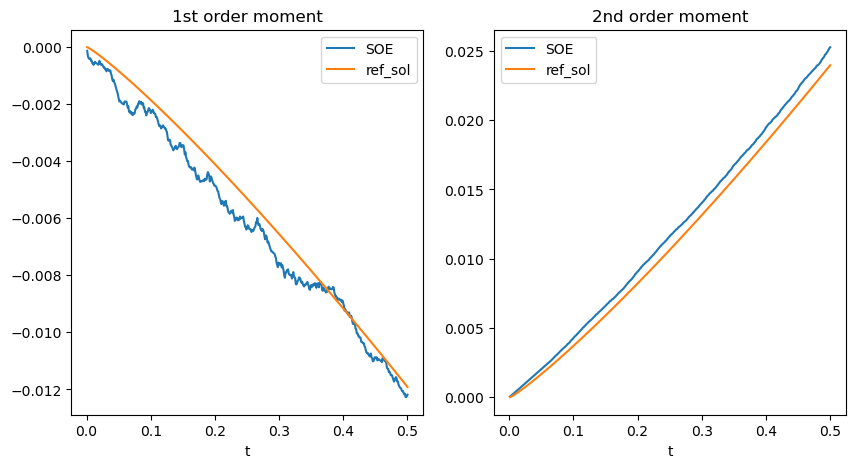

In [17]:
x = heston.grid[1:]
my_M_1, my_M_2 = my_moment[0,:], my_moment[1,:]
ref_M_1, ref_M_2 = ref_moment[0,:], ref_moment[1,:]

# 1st order moment plot 
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
l_1,= plt.plot(x, my_M_1)
l_2,= plt.plot(x, ref_M_1)
plt.xlabel("t")
plt.legend(handles = [l_1,l_2], labels=["SOE","ref_sol"], loc = 'best')
plt.title("1st order moment")

#2nd order moment plot 
plt.subplot(1,2,2)
r_1,= plt.plot(x, my_M_2)
r_2,= plt.plot(x, ref_M_2)
plt.xlabel("t")
plt.legend(handles = [r_1,r_2], labels=["SOE","ref_sol"], loc = 'best')
plt.title("2nd order moment")
plt.show()